# Table of Contents

[Notebook Workflow Step-by-Step for CTX](#notebook-workflow-step-by-step-for-ctx)

[Setup variables and configs](#setup-variables-and-configs)

1. [1. Download images](#1-download-images)
    - [Preview left and right image](#preview-left-and-right-image)
2. [2. First Step of CTX processing lev1eo](#2-first-step-of-ctx-processing-lev1eo)
3. [3. Metadata init](#3-metadata-init)
    - [3.1. Stereo Quality Report](#31-stereo-quality-report)
    - [Downsample images if requested](#downsample-images-if-requested)
4. [4. Bundle adjustment](#4-bundle-adjustment)
5. [5. Stereo first run (steps 1-3 of stereo in ASP)](#5-stereo-first-run-steps-1-3-of-stereo-in-asp)
6. [6. Stereo first run (step 4 of stereo in ASP)](#6-stereo-first-run-step-4-of-stereo-in-asp)
7. [7. Produce low resolution DEM for map projection](#7-produce-low-resolution-dem-for-map-projection)
8. [8. Make GoodPixelMap and Hillshade Previews](#8-make-goodpixelmap-and-hillshade-previews)
    - [Good Pixel Map](#good-pixel-map)
    - [Hillshade of low res DEM](#hillshade-of-low-res-dem)
9. [9. Mapproject ctx against 100m DEM](#9-mapproject-ctx-against-100m-dem)
10. [10. Calculate Better DEM using prior](#10-calculate-better-dem-using-prior)
11. [11. PC alignment (Step 5)](#11-pc-alignment-step-5)
    - [Good Pixel Preview](#good-pixel-preview)
    - [Hillshade of higher res DEM](#hillshade-of-higher-res-dem)
    - [Show pedr data](#show-pedr-data)
12. [12. Start of PC align portion](#12-start-of-pc-align-portion)


# Notebook Workflow Step-by-Step for CTX

Now that we have run the Jupyter Notebook based workflows through the command line interface, we can look at each step that was run and describe what happened in more detail. Note that the function docstrings are also available to describe the parameters of a given step, and what that step does. Below is an export of all the codeblocks in the notebook workflow, additional markdown cells are included in the files but are not important to reproduce here. This workflow replicates the same workflow used by the asp_scripts project.

First define all the parameters for the notebook for papermill. The notebook includes a cell metadata tag for papermill to allow these parameters to be defined at runtime. First we need the left and right image ids, the left image typically has the lower emission angle. ASAP will check the metadata of the images to ensure the correct order is provided. The config1 and config2 parameters are paths to stereo.default files the user has to configure the Ames Stereo Pipeline. The first config file is the only required parameter, config2 gives you to use higher quality parameters for the 2nd pass CTX DEM. The “dem_gsd” and “img_gsd” parameters control the number of pixels per pixel the final DEM and orthorectified images have. These default to 24 and 6 meters per pixel which works for generally any CTX image pair.

Generally, most CTX images are captured at around 5.5 meters per pixel (GSD) so we pick 6 mpp as a reasonable default. By convention, the DEM post spacing should be at least 3X the image GSD. ASAP defaults to 4X the image GSD to be a bit more conservative, resulting in 24 meters per pixel. Output_path is typically left blank to default to the current working directory. The maxdisp parameter controls the maximum expected disparity (distance) between the intermediate CTX DEM and the reference topography. Leaving this as ‘None’ will allow ASAP to estimate the disparity for you. The downsample parameter allows you to downsample the imagery by a factor of the value to reduce processing times, a downsample of 4 will reduce the number of pixels by a factor of 4. The pedr_list variable points to the local copy of a file containing a list of all the paths to all of the MOLA PEDR data. By default this is set to None to use the ODE REST API to grab the necessary PEDR data, which is much faster anyways.


# Setup variables and configs

In [5]:
from src.asp_wrapper import AmesPipelineWrapper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
left  = 'K14_059010_0916'
right = 'U15_076642_0916'

# left = 'P02_001981_1823'
# right = 'P03_002258_1817'


config1 = None
config2 = None
dem_gsd  = 24.0
img_gsd  = 6.0
output_path = None
max_disp = None
downsample = None
refdem = None
step_kwargs = {}
# todo: add reference_dem and use to conditional pedr things

`if config2 == None:`
`    config2 = config1`

`!cat {config1}`

`!cat {config2}`


In [7]:
from IPython.display import Image
from pathlib import Path
from src.ctx import CTX
from src.moody import ODE
import math
import os

default_output_dir = os.path.join(os.getcwd(), 'output')

# Initialize the ODE and CTX classes
ctx = CTX()
ode = ODE(https=True)
asp = AmesPipelineWrapper()

# Reassign left and right to the correct order
left, right = ctx.get_ctx_order(left, right)

output_path = os.path.join(default_output_dir, f'a_{left}_{right}/') if not output_path else output_path
print("Output directory: ", output_path)

if not os.path.exists(output_path):
    os.makedirs(output_path)

print("Left image PID:  %s\nRight image PID: %s" % (left, right))

Output directory:  /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/
Left image PID:  K14_059010_0916
Right image PID: U15_076642_0916


# 1. Download images


Now we are getting to the heart of the notebook workflow. First use step-one to download our left and right images using the moody tool. At the end of the command you can see we are using standard bash to redirect stdout and stderr to two log files, the first a log just for this step, the second a cumulative log file for the whole job.

`asap ctx step_1 {left} {right} 2>&1 | tee -i -a ./1_download.log ./full_log.log`


In [8]:
# ctx.step_1()
# ctx.generate_ctx_pair_list(left, right)
left_id = ctx.get_full_ctx_id(left)
right_id = ctx.get_full_ctx_id(right)
# download files
left_path = ode.download_ctx_edr(left_id, output_path)
right_path = ode.download_ctx_edr(right_id, output_path)

left_stem = os.path.join(os.path.dirname(left_path), f'{left_id}')
right_stem = os.path.join(os.path.dirname(right_path), f'{right_id}')

asp.setup_pair_info(output_path, left_stem, right_stem)

File K14_059010_0916_XN_88S273W.IMG already exists, skipping download.
File U15_076642_0916_XN_88S273W.IMG already exists, skipping download.


## Preview left and right image

In [9]:
!gdal_translate -of GTiff {left_path} {left_stem}.tif
!gdal_translate -of GTiff {right_path} {right_stem}.tif

!gdal_translate -of PNG {left_path} {left_stem}.png
!gdal_translate -of PNG {right_path} {right_stem}.png

Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5056, 7168
0...10...20...30...40...50...60...70...80...90...100 - done.


/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


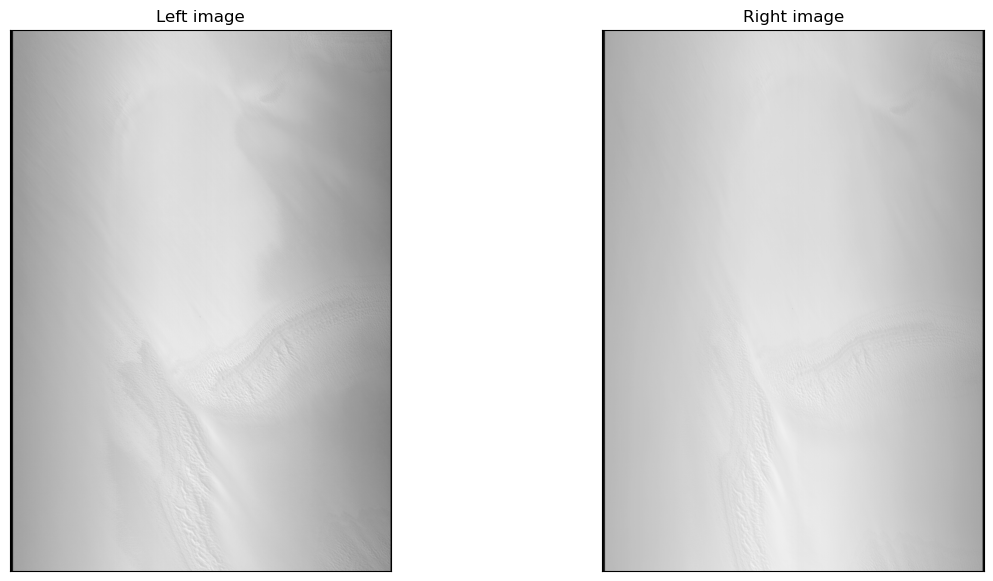

In [10]:
import matplotlib.pyplot as plt
import rasterio

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.tight_layout()

with rasterio.open(f'{left_stem}.tif', 'r') as src:
    img = ax1.imshow(src.read(1), cmap='gray')
    ax1.set_xticks([])  # Remove x-axis ticks
    ax1.set_yticks([])
    ax1.set_title('Left image')

with rasterio.open(f'{right_stem}.tif', 'r') as src:
    img = ax2.imshow(src.read(1), cmap='gray')
    ax2.set_xticks([])  # Remove x-axis ticks
    ax2.set_yticks([])
    ax2.set_title('Right image')

plt.show()

# 2. First Step of CTX processing lev1eo

Now we replicate the preprocessing from the asp_scripts project/ames stereo pipeline using ISIS commands. This step will run these steps in the following order:

1) `mroctx2isis`
2) `spiceinit`
3) `spicefit`
4) `ctxcal`
5) `ctxevenodd`

`$ asap ctx step_2 {asap.kwarg_parse(step_kwargs, 'step_2')} 2>&1 | tee -i -a ./2_ctxedr2lev1eo.log ./full_log.log`

Для корректной работы команд необходимо предзагрузить IsisData отсюда: https://astrogeology.usgs.gov/docs/how-to-guides/environment-setup-and-maintenance/isis-data-area/

Т.к. работаем с миссей Mars Reconnaissance Orbiter, нужно ввести `downloadIsisData mro $ISISDATA`

In [11]:
from src.utils.common import run_parallel, rich_logger


# @rich_logger
# def step_2(ctx_wrapper: CTX, with_web=False):
#     """
#     ISIS3 CTX preprocessing, replaces ctxedr2lev1eo.sh
#
#     :param with_web: if true attempt to use webservices for SPICE kernel data
#     """
files = [output_path + left_id, output_path + right_id]
run_parallel(asp.mroctx2isis, [f'from={i}.IMG to={i}.cub' for i in files], )

run_parallel(asp.spiceinit, [f'from={i}.cub web=yes' for i in files])

run_parallel(asp.spicefit, [f'from={i}.cub' for i in files])
#
run_parallel(asp.ctxcal, [f'from={i}.cub to={i}.lev1.cub' for i in files])

# for cub in cubs:
#     cub.unlink()

"""
**USER ERROR** The CTX image [/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_N13_067270_0910_N12_067124_0910/N13_067270_0910_XN_89S005W.lev1.cub] has already been radiometrically calibrated.
"""
# lev1cubs = list(Path(output_path).glob('*.lev1.cub'))

run_parallel(asp.ctxevenodd, [f'from={i}.lev1.cub to={i}.lev1.eo.cub' for i in files])
# for lc in lev1cubs:
#     lc.unlink()


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/mroctx2isis from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.IMG to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/mroctx2isis from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.IMG to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/spiceinit from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.cub web=yes: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/sp

Group = Kernels
  NaifFrameCode             = -74021
  LeapSecond                = $base/kernels/lsk/naif0012.tls
  TargetAttitudeShape       = $mro/kernels/pck/pck00008.tpc
  TargetPosition            = (Table, $base/kernels/spk/de430.bsp,
                               $base/kernels/spk/mar097.bsp)
  InstrumentPointing        = (Table,
                               $mro/kernels/ck/mro_sc_psp_190226_190304.bc,
                               $mro/kernels/fk/mro_v16.tf)
  Instrument                = Null
  SpacecraftClock           = $mro/kernels/sclk/MRO_SCLKSCET.00113.65536.tsc
  InstrumentPosition        = (Table,
                               $mro/kernels/spk/mro_psp50_ssd_mro95a.bsp)
  InstrumentAddendum        = $mro/kernels/iak/mroctxAddendum005.ti
  ShapeModel                = $base/dems/molaMarsPlanetaryRadius0005.cub
  InstrumentPositionQuality = Reconstructed
  InstrumentPointingQuality = Reconstructed
  CameraVersion             = 1
End_Group


This function(PvlObject::addLogGroup) will be depreciated in ISIS3 v9.0 in favor of Application::appendLogGroup


Group = Kernels
  NaifFrameCode             = -74021
  LeapSecond                = $base/kernels/lsk/naif0012.tls
  TargetAttitudeShape       = $mro/kernels/pck/pck00008.tpc
  TargetPosition            = (Table, $base/kernels/spk/de430.bsp,
                               $base/kernels/spk/mar097.bsp)
  InstrumentPointing        = (Table,
                               $mro/kernels/ck/mro_sc_psp_221129_221205.bc,
                               $mro/kernels/fk/mro_v16.tf)
  Instrument                = Null
  SpacecraftClock           = $mro/kernels/sclk/MRO_SCLKSCET.00113.65536.tsc
  InstrumentPosition        = (Table,
                               $mro/kernels/spk/mro_psp65_ssd_mro95a.bsp)
  InstrumentAddendum        = $mro/kernels/iak/mroctxAddendum005.ti
  ShapeModel                = $base/dems/molaMarsPlanetaryRadius0005.cub
  InstrumentPositionQuality = Reconstructed
  InstrumentPointingQuality = Reconstructed
  CameraVersion             = 1
End_Group


This function(PvlObject::addLogGroup) will be depreciated in ISIS3 v9.0 in favor of Application::appendLogGroup
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/spicefit from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/spicefit from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/ctxcal from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.cub to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.cub: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/ctxcal from=/mnt/c/Users/Ivan/Documents/P

[, ]

In [12]:
!ls {output_path}

K14_059010_0916_XN_88S273W.IMG
K14_059010_0916_XN_88S273W.cub
K14_059010_0916_XN_88S273W.lev1.cub
K14_059010_0916_XN_88S273W.lev1.eo.caminfo
K14_059010_0916_XN_88S273W.lev1.eo.cub
K14_059010_0916_XN_88S273W.lev1.eo.json
K14_059010_0916_XN_88S273W.lev1.eo_camrange.txt
K14_059010_0916_XN_88S273W.png
K14_059010_0916_XN_88S273W.png.aux.xml
K14_059010_0916_XN_88S273W.tif
U15_076642_0916_XN_88S273W.IMG
U15_076642_0916_XN_88S273W.cub
U15_076642_0916_XN_88S273W.lev1.cub
U15_076642_0916_XN_88S273W.lev1.eo.caminfo
U15_076642_0916_XN_88S273W.lev1.eo.cub
U15_076642_0916_XN_88S273W.lev1.eo.json
U15_076642_0916_XN_88S273W.png
U15_076642_0916_XN_88S273W.png.aux.xml
U15_076642_0916_XN_88S273W.tif
adjust
dem
print.prt
results


# 3. Metadata init

Now we create a number of metadata files used by the asp_scripts project to simplify future command calls. We also copy our preprocessed CTX cub files into a new working directory where all the stereo products will be computed. This new directory name uses both image IDs joined by an underscore ‘{left_id}_{right_id}’, for example: “B03_010644_1889_XN_08N001W_P02_001902_1889_XI_08N001W”.

`$ asap ctx step_3`

In [13]:
# """
#         Create various processing files for future steps
#         # todo: deduplicate with hirise side
#         """
# ctx.cs.create_stereopairs_lis()
# ctx.cs.create_stereodirs_lis()
# ctx.cs.create_stereodirs()
# ctx.cs.create_stereopair_lis()
# # copy the cub files into the both directory
# _, _, both = self.cs.parse_stereopairs()
# sh.mv('-n', sh.glob('./*.cub'), f'./{both}/') # Rewrite with !

## 3.1. Stereo Quality Report

In [14]:
qual_report = asp.get_stereo_quality_report(f'{output_path + left_id}.lev1.eo.cub', f'{output_path + right_id}.lev1.eo.cub')
print(qual_report)

INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/caminfo from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.caminfo polygon=True', pid 28595>: process started
INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/caminfo from=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub to=/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.caminfo polygon=True', pid 28615>: process started



    Stereo Pair Quality Report:

    Image 1: K14_059010_0916_XN_88S273W.lev1.eo.cub
    Image 2: U15_076642_0916_XN_88S273W.lev1.eo.cub
                            Image 1  Image 2
           Incidence Angle:  84.00    83.78
                   Quality:  -1.27    -1.25
            Emission Angle:  28.36    32.08
                   Quality:   0.74     0.57
               Phase Angle:  98.72   102.55
                   Quality:   0.35     0.29

     Subspacecraft Azimuth:  64.42    77.33
          Subsolar Azimuth: 311.48   311.48
                   Quality:       1.00
    Ground Sample Distance:   6.18     6.58
                   Quality:       0.96

    Stereo Overlap Fraction: 0.81
            Overlap Quality: 1.00

                Parallax Angle: 7.47
    Parallax/Height Ratio (dp): 0.16
       Stereo Strength Quality: 0.19

    Stereo Tip Distance (dsh): 1.37
         Illumination Quality: 0.47
    
    This pair of images probably won't make a good stereo pair because there were
 

### Downsample images if requested

In [15]:
if downsample:
    true_img_gsd_left = asp.get_image_gsd(f'{left}_{right}/{left}.lev1eo.cub')
    true_img_gsd_right = asp.get_image_gsd(f'{left}_{right}/{right}.lev1eo.cub')
    # take conservative approach, pick worst image GSD
    res_gsd = max(true_img_gsd_left, true_img_gsd_right)
    # this is because rescale in ISIS does not update GSD in metadata
    asp.rescale_and_overwrite(factor=downsample)
    img_gsd = math.ceil(res_gsd)*downsample
    dem_gsd = 4*img_gsd
    print('new img gsd', img_gsd)
    print('new dem gsd', dem_gsd)

# 4. Bundle adjustment

We will use the parallel_bundle_adjust command from Ames Stereo Pipeline to refine the spacecraft position and orientation. The user can later re-run this step with more advanced options or GCPs if so desired.

`!asap ctx step_4 {asap.kwarg_parse(step_kwargs, 'step_4')} 2>&1 | tee -i -a ./2_bundle_adjust.log ./full_log.log`

In [16]:
"""
Bundle Adjust CTX

Run bundle adjustment on the CTX map projected data

:param vargs: variable length additional positional arguments to pass to bundle adjust
:param bundle_adjust_prefix: prefix for bundle adjust output
:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras
"""
asp.bundle_adjust(bundle_adjust_prefix='adjust/ba', postfix='.lev1.eo.cub',
               camera_postfix='.lev1.eo.json')

# Started: bundle_adjust (Bundle adjustment wrapper), at: 2025-06-02 09:02:31.740380


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/isd_generate -v --max_workers 16 /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub: process started


Attempting to pre-parse label file
Attempting to pre-parse label file
First parse attempt failed with
(LexerError(...), 'Expecting an Aggregation Block, an Assignment Statement, or an End Statement, but found "#" : line 95 column 1 (char 2695) near "Smoothed"')
First parse attempt failed with
(LexerError(...), 'Expecting an Aggregation Block, an Assignment Statement, or an End Statement, but found "#" : line 95 column 1 (char 2697) near "Smoothed"')
Successfully pre-parsed label file
Trying <class 'ale.drivers.voyager_drivers.VoyagerCameraIsisLabelNaifSpiceDriver'>
Failed: 'Mars_Reconnaissance_Orbiter'

Successfully pre-parsed label file
Trying <class 'ale.drivers.voyager_drivers.VoyagerCameraIsisLabelNaifSpiceDriver'>
Failed: 'Mars_Reconnaissance_Orbiter'



Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/voyager_drivers.py", line 22, in instrument_id
    return sc_lookup[super().spacecraft_name] + '_' + sensor_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/voyager_drivers.py", line 22, in instrument_id
    return sc_lookup[super().spacecraft_name] + '_' + sensor_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^


Trying <class 'ale.drivers.hayabusa_drivers.HayabusaAmicaIsisLabelNaifSpiceDriver'>


KeyError: 'Mars_Reconnaissance_Orbiter'
KeyError: 'Mars_Reconnaissance_Orbiter'


Failed: 'CTX'

Trying <class 'ale.drivers.hayabusa_drivers.HayabusaAmicaIsisLabelNaifSpiceDriver'>
Failed: 'CTX'



Traceback (most recent call last):
Traceback (most recent call last):


Trying <class 'ale.drivers.hayabusa_drivers.HayabusaNirsIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.hayabusa_drivers.HayabusaNirsIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'




  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/hayabusa_drivers.py", line 21, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/hayabusa_drivers.py", line 21, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id


Trying <class 'ale.drivers.clementine_drivers.ClementineIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.clementine_drivers.ClementineIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.dawn_drivers.DawnFcIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.dawn_drivers.DawnFcIsisLabelNaifSpiceDriver'>
Failed: 'FilterNumber'
Failed: 'FilterNumber'




  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/hayabusa_drivers.py", line 60, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/hayabusa_drivers.py", line 60, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/clementine_drivers.py", line 36, in instrument_id
    return lookup_table[super().instrument_id]
         

Trying <class 'ale.drivers.dawn_drivers.DawnFcPds3NaifSpiceDriver'>
Trying <class 'ale.drivers.dawn_drivers.DawnFcPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'



  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/clementine_drivers.py", line 36, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 236, in instrument_id
    filter_number = self.filter_number
                    ^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 253, in filter_number
    return self.label["IsisCube"]["BandBin"]["FilterNumber"]
           ~~~~~~~~~~~~~~~~~~~~~~

Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.dawn_drivers.DawnVirIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.dawn_drivers.DawnVirIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.selene_drivers.KaguyaMiIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.selene_drivers.KaguyaMiIsisLabelNaifSpiceDriver'>
Failed: 'BaseBand'

Failed: 'BaseBand'



  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'FilterNumber'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 236, in instrument_id
    filter_number = self.filter_number
                    ^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 253, in filter_number
    return self.label["IsisCube"]["BandBin"]["FilterNumber"]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'Filter

Trying <class 'ale.drivers.selene_drivers.KaguyaMiPds3NaifSpiceDriver'>
Failed: None
Trying <class 'ale.drivers.selene_drivers.KaguyaMiPds3NaifSpiceDriver'>

Failed: None

Trying <class 'ale.drivers.selene_drivers.KaguyaTcIsisLabelNaifSpiceDriver'>
Failed: 'SwathModeId'



Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 48, in instrument_id
    instrument_id = super().instrument_id
                    ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 48

Trying <class 'ale.drivers.selene_drivers.KaguyaTcIsisLabelNaifSpiceDriver'>
Failed: 'SwathModeId'

Trying <class 'ale.drivers.selene_drivers.KaguyaTcPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.selene_drivers.KaguyaTcPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.lro_drivers.LroLrocNacIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.lro_drivers.LroLrocNacIsisLabelNaifSpiceDriver'>
Failed: 'CTX'



    instrument_id = super().instrument_id
                    ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 419, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'


Trying <class 'ale.drivers.lro_drivers.LroLrocNacPds3LabelNaifSpiceDriver'>
Trying <class 'ale.drivers.lro_drivers.LroLrocNacPds3LabelNaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'
Failed: 'INSTRUMENT_ID'


Trying <class 'ale.drivers.lro_drivers.LroLrocWacIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.lro_drivers.LroLrocWacIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.lro_drivers.LroMiniRfIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Trying <class 'ale.drivers.lro_drivers.LroMiniRfIsisLabelNaifSpiceDriver'>

Failed: 'CTX'

Trying <class 'ale.drivers.clipper_drivers.ClipperEISNACFCIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.clipper_drivers.ClipperEISNACFCIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'



  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/dawn_drivers.py", line 419, in instrument_id
    return lookup_table[super().instrument_id]
           ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 1142, in instrument_id
    id = f"LISM_{self.base_band}"
                 ^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 1127, in base_band
    base_band = band_map[self.label['IsisCube']['BandBin']['BaseBand']]
                         ~~~~~~~~~~~~

Trying <class 'ale.drivers.clipper_drivers.ClipperEISNACPBIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.clipper_drivers.ClipperEISNACPBIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.clipper_drivers.ClipperEISWACFCIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.clipper_drivers.ClipperEISWACFCIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.clipper_drivers.ClipperEISWACPBIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.clipper_drivers.ClipperEISWACPBIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.co_drivers.CassiniIssIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Trying <class 'ale.drivers.co_drivers.CassiniIssIsisLabelNaifSpiceDriver'>

Failed: 'CTX'



  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'BaseBand'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 1142, in instrument_id
    id = f"LISM_{self.base_band}"
                 ^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 1127, in base_band
    base_band = band_map[self.label['IsisCube']['BandBin']['BaseBand']]
                         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 

Trying <class 'ale.drivers.co_drivers.CassiniIssPds3LabelNaifSpiceDriver'>
Trying <class 'ale.drivers.co_drivers.CassiniIssPds3LabelNaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'

Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.osirisrex_drivers.OsirisRexCameraIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.osirisrex_drivers.OsirisRexCameraIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.mro_drivers.MroCrismIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.mro_drivers.MroCrismIsisLabelNaifSpiceDriver'>
Failed: 'SensorId'
Failed: 'SensorId'




  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 860, in instrument_id
    id = f"LISM_{self.base_band}"
                 ^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 845, in base_band
    base_band = band_map[self.label.get("BASE_BAND")]
                ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyError: None
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 860, in instrument_id
    id = f"LISM_{self.base_band}"
                 ^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packag

Trying <class 'ale.drivers.mro_drivers.MroCtxIsisLabelNaifSpiceDriver'>
Failed: ale.spice_root is not set, cannot search for metakernels. ale.spice_root = "None"
Trying <class 'ale.drivers.mro_drivers.MroCtxIsisLabelNaifSpiceDriver'>

Failed: ale.spice_root is not set, cannot search for metakernels. ale.spice_root = "None"

Trying <class 'ale.drivers.mro_drivers.MroCtxPds3LabelNaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.mro_drivers.MroCtxPds3LabelNaifSpiceDriver'>


    base_band = band_map[self.label.get("BASE_BAND")]
                ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyError: None
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 542, in instrument_id
    swath = self.label["IsisCube"]["Instrument"]["SwathModeId"][0]
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'SwathModeId'
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id


Failed: 'INSTRUMENT_ID'

Trying <class 'ale.drivers.mro_drivers.MroHiRiseIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.mro_drivers.MroHiRiseIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.mro_drivers.MroMarciIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Trying <class 'ale.drivers.mro_drivers.MroMarciIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Trying <class 'ale.drivers.mex_drivers.MexHrscIsisLabelNaifSpiceDriver'>

Failed: Instrument ID is wrong.

Trying <class 'ale.drivers.mex_drivers.MexHrscIsisLabelNaifSpiceDriver'>
Failed: Instrument ID is wrong.



  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 542, in instrument_id
    swath = self.label["IsisCube"]["Instrument"]["SwathModeId"][0]
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'SwathModeId'
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 205, in instrument_id
    instrument = super().instrument_id
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']

Trying <class 'ale.drivers.mex_drivers.MexHrscPds3NaifSpiceDriver'>
Trying <class 'ale.drivers.mex_drivers.MexHrscPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'
Failed: 'INSTRUMENT_ID'


Trying <class 'ale.drivers.mex_drivers.MexSrcPds3NaifSpiceDriver'>
Trying <class 'ale.drivers.mex_drivers.MexSrcPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'
Failed: 'INSTRUMENT_ID'


Trying <class 'ale.drivers.mariner_drivers.Mariner10IsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.mariner_drivers.Mariner10IsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.mgs_drivers.MgsMocNarrowAngleCameraIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.mgs_drivers.MgsMocNarrowAngleCameraIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'




  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 205, in instrument_id
    instrument = super().instrument_id
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
Tra

Trying <class 'ale.drivers.mgs_drivers.MgsMocWideAngleCameraIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.mgs_drivers.MgsMocWideAngleCameraIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.chandrayaan_drivers.Chandrayaan1M3IsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.chandrayaan_drivers.Chandrayaan1M3IsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.chandrayaan_drivers.Chandrayaan1MRFFRIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.chandrayaan_drivers.Chandrayaan1MRFFRIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.mess_drivers.MessengerMdisIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.mess_drivers.MessengerMdisIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.mess_drivers.MessengerMdisPds3NaifSpiceDriver'>
Trying <class 'ale.drivers.mess_drivers.MessengerMdisPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_ID'

Failed: 'INST

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 300, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 300, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/

Trying <class 'ale.drivers.nh_drivers.NewHorizonsLeisaIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Trying <class 'ale.drivers.nh_drivers.NewHorizonsLeisaIsisLabelNaifSpiceDriver'>

Failed: 'CTX'

Trying <class 'ale.drivers.nh_drivers.NewHorizonsLorriIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.nh_drivers.NewHorizonsLorriIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.nh_drivers.NewHorizonsMvicIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.nh_drivers.NewHorizonsMvicIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.nh_drivers.NewHorizonsMvicTdiIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.nh_drivers.NewHorizonsMvicTdiIsisLabelNaifSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.viking_drivers.VikingIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.viking_drivers.VikingIsisLabelNaifSpiceDriver'>
Failed: Instrument ID [CTX] is wrong.
Failed: Instrument ID [CTX] is wrong.




    instrument = super().instrument_id
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 38, in instrument_id
    instrument = super().instrument_id
                 ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~

Trying <class 'ale.drivers.lo_drivers.LoHighCameraIsisLabelNaifSpiceDriver'>
Failed: 'Mars_Reconnaissance_Orbiter'

Trying <class 'ale.drivers.lo_drivers.LoHighCameraIsisLabelNaifSpiceDriver'>
Failed: 'Mars_Reconnaissance_Orbiter'

Trying <class 'ale.drivers.galileo_drivers.GalileoSsiIsisLabelNaifSpiceDriver'>
Trying <class 'ale.drivers.galileo_drivers.GalileoSsiIsisLabelNaifSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.msl_drivers.MslMastcamPds3NaifSpiceDriver'>
Trying <class 'ale.drivers.msl_drivers.MslMastcamPds3NaifSpiceDriver'>
Failed: 'INSTRUMENT_HOST_ID'

Failed: 'INSTRUMENT_HOST_ID'

Trying <class 'ale.drivers.selene_drivers.KaguyaTcIsisLabelIsisSpiceDriver'>
Trying <class 'ale.drivers.selene_drivers.KaguyaTcIsisLabelIsisSpiceDriver'>
Failed: Instrument ID: 'CTX' not in VALID_INSTRUMENT_IDS list. Failing.
Failed: Instrument ID: 'CTX' not in VALID_INSTRUMENT_IDS list. Failing.


Trying <class 'ale.drivers.lro_drivers.LroLrocNacIsisLabelIsisSpiceDriver'>


  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 1094, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 1094, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyErro

Trying <class 'ale.drivers.lro_drivers.LroLrocNacIsisLabelIsisSpiceDriver'>
Failed: 'CTX'
Failed: 'CTX'


Trying <class 'ale.drivers.lro_drivers.LroLrocWacIsisLabelIsisSpiceDriver'>
Trying <class 'ale.drivers.lro_drivers.LroLrocWacIsisLabelIsisSpiceDriver'>
Failed: 'CTX'

Failed: 'CTX'

Trying <class 'ale.drivers.co_drivers.CassiniIssIsisLabelIsisSpiceDriver'>
Failed: 'CTX'
Trying <class 'ale.drivers.co_drivers.CassiniIssIsisLabelIsisSpiceDriver'>

Failed: 'CTX'

Trying <class 'ale.drivers.mro_drivers.MroCtxIsisLabelIsisSpiceDriver'>
Trying <class 'ale.drivers.mro_drivers.MroCtxIsisLabelIsisSpiceDriver'>


Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 730, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 730, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/as

Success with:  <ale.drivers.mro_drivers.MroCtxIsisLabelIsisSpiceDriver object at 0x71ca4d832c90>
Success with:  <ale.drivers.mro_drivers.MroCtxIsisLabelIsisSpiceDriver object at 0x71ca4c51c650>


  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mariner_drivers.py", line 24, in instrument_id
    return inst_id_lookup[super().instrument_id]
           ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mgs_drivers.py", line 37, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mgs_drivers.py", line 37, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^

ISD:
 {
  "isis_camera_version": 1,
  "image_lines": 7168,
  "image_samples": 5000,
  "name_platform": "Mars_Reconnaissance_Orbiter",
  "name_sensor": "CONTEXT CAMERA",
  "reference_height": {
    "maxheight": 1000,
    "minheight": -1000,
    "unit": "m"
  },
  "name_model": "USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL",
  "interpolation_method": "lagrange",
  "line_scan_rate": [
    [
      0.5,
      -6.727167963981628,
      0.001877
    ]
  ],
  "starting_ephemeris_time": 723234427.4756721,
  "center_ephemeris_time": 723234434.2028401,
  "radii": {
    "semimajor": 3396.19,
    "semiminor": 3376.2,
    "unit": "km"
  },
  "body_rotation": {
    "time_dependent_frames": [
      10014,
      1
    ],
    "ck_table_start_time": 723234427.4756721,
    "ck_table_end_time": 723234440.9300082,
    "ck_table_original_size": 2,
    "ephemeris_times": [
      723234427.4756721,
      723234440.9300082
    ],
    "quaternions": [
      [
        0.32389216326416764,
        0.1478810485948716,


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mgs_drivers.py", line 169, in instrument_id
    pref = id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mgs_drivers.py", line 169, in instrument_id
    pref = id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id


        -0.2819287322536205,
        0.8909215745352705
      ],
      [
        0.32431695020468043,
        0.14774659792304662,
        -0.2819992152598753,
        0.8907670297024441
      ]
    ],
    "angular_velocities": [
      [
        3.162265666009365e-05,
        -2.8817699964121802e-05,
        5.651399139822554e-05
      ],
      [
        3.162265666005539e-05,
        -2.8817699964543963e-05,
        5.651399139803168e-05
      ]
    ],
    "reference_frame": 1
  },
  "instrument_pointing": {
    "time_dependent_frames": [
      -74000,
      1
    ],
    "ck_table_start_time": 723234427.44678,
    "ck_table_end_time": 723234440.94701,
    "ck_table_original_size": 136,
    "ephemeris_times": [
      723234427.44678,
      723234427.5467817,
      723234427.6467834,
      723234427.746785,
      723234427.8467867,
      723234427.9467884,
      723234428.0467902,
      723234428.1467919,
      723234428.2467936,
      723234428.3467953,
      723234428.446797,
      72

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/chandrayaan_drivers.py", line 24, in instrument_id
    return inst_id_lookup[super().instrument_id]
          ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/chandrayaan_drivers.py", line 24, in instrument_id
    return inst_id_lookup[super().instrument_id]
          ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/chandrayaan_drivers.py", line 66, in instrument_id
    return inst_id_lookup[super().instrumen

      723234428.7468021,
      723234428.8468038,
      723234428.9468055,
      723234429.0468073,
      723234429.146809,
      723234429.2468107,
      723234429.3468124,
      723234429.4468141,
      723234429.5468158,
      723234429.6468174,
      723234429.7468191,
      723234429.8468208,
      723234429.9468225,
      723234430.0468243,
      723234430.146826,
      723234430.2468277,
      723234430.3468294,
      723234430.4468311,
      723234430.5468328,
      723234430.6468345,
      723234430.7468362,
      723234430.8468379,
      723234430.9468396,
      723234431.0468413,
      723234431.1468431,
      723234431.2468448,
      723234431.3468465,
      723234431.4468482,
      723234431.5468498,
      723234431.6468515,
      723234431.7468532,
      723234431.8468549,
      723234431.9468566,
      723234432.0468583,
      723234432.1468601,
      723234432.2468618,
      723234432.3468635,
      723234432.4468652,
      723234432.5468669,
      723234432.6468686,
  

          ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/chandrayaan_drivers.py", line 66, in instrument_id
    return inst_id_lookup[super().instrument_id]
          ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mess_drivers.py", line 288, in instrument_id
    return ID_LOOKUP[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instr

      723234432.846872,
      723234432.9468737,
      723234433.0468754,
      723234433.146877,
      723234433.2468789,
      723234433.3468806,
      723234433.4468822,
      723234433.546884,
      723234433.6468856,
      723234433.7468873,
      723234433.846889,
      723234433.9468907,
      723234434.0468924,
      723234434.1468941,
      723234434.2468959,
      723234434.3468976,
      723234434.4468993,
      723234434.546901,
      723234434.6469027,
      723234434.7469044,
      723234434.8469061,
      723234434.9469078,
      723234435.0469095,
      723234435.1469111,
      723234435.246913,
      723234435.3469146,
      723234435.4469163,
      723234435.546918,
      723234435.6469197,
      723234435.7469214,
      723234435.8469231,
      723234435.9469248,
      723234436.0469265,
      723234436.1469282,
      723234436.2469299,
      723234436.3469317,
      723234436.4469334,
      723234436.5469351,
      723234436.6469368,
      723234436.7469385,
      7

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mess_drivers.py", line 288, in instrument_id
    return ID_LOOKUP[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mess_drivers.py", line 132, in instrument_id
    return ID_LOOKUP[super().instrument_id]
                     ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
      

      723234436.9469419,
      723234437.0469435,
      723234437.1469452,
      723234437.2469469,
      723234437.3469487,
      723234437.4469504,
      723234437.5469521,
      723234437.6469538,
      723234437.7469555,
      723234437.8469572,
      723234437.9469589,
      723234438.0469606,
      723234438.1469623,
      723234438.246964,
      723234438.3469657,
      723234438.4469675,
      723234438.5469692,
      723234438.6469709,
      723234438.7469726,
      723234438.8469743,
      723234438.946976,
      723234439.0469776,
      723234439.1469793,
      723234439.246981,
      723234439.3469827,
      723234439.4469845,
      723234439.5469862,
      723234439.6469879,
      723234439.7469896,
      723234439.8469913,
      723234439.946993,
      723234440.0469947,
      723234440.1469964,
      723234440.2469981,
      723234440.3469998,
      723234440.4470016,
      723234440.5470033,
      723234440.647005,
      723234440.7470067,
      723234440.8470083,
     

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/mess_drivers.py", line 132, in instrument_id
    return ID_LOOKUP[super().instrument_id]
                     ^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 33, in instrument_id
    return self.label['INSTRUMENT_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'INSTRUMENT_ID'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id


    "quaternions": [
      [
        0.759223562879773,
        -0.2733884259819908,
        -0.15222541510909332,
        0.5706713354480819
      ],
      [
        0.7592407223121771,
        -0.2733680149666509,
        -0.15218743233853202,
        0.5706684145931693
      ],
      [
        0.7592578878285993,
        -0.2733475904653916,
        -0.1521494552029325,
        0.5706654868119061
      ],
      [
        0.7592750594283287,
        -0.27332715247991907,
        -0.15211148370283226,
        0.5706625521032987
      ],
      [
        0.7592922371106552,
        -0.2733067010119394,
        -0.15207351783876744,
        0.5706596104663525
      ],
      [
        0.7593094208748673,
        -0.27328623606315844,
        -0.1520355576112729,
        0.5706566619000732
      ],
      [
        0.7593266107407493,
        -0.2732657576108624,
        -0.1519976029756411,
        0.5706537063999387
      ],
      [
        0.759343806666606,
        -0.2732452657055806,


  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 123, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 123, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 34, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^

        0.5706507439720002
      ],
      [
        0.7593610086722133,
        -0.2732247603246149,
        -0.1519217107083136,
        0.5706477746117434
      ],
      [
        0.7593782167568589,
        -0.27320424146967076,
        -0.15188377303243086,
        0.5706447983181727
      ],
      [
        0.75939543091983,
        -0.27318370914245366,
        -0.1518458409957739,
        0.5706418150902923
      ],
      [
        0.7594126511604133,
        -0.2731631633446689,
        -0.15180791459887014,
        0.5706388249271062
      ],
      [
        0.7594298774778956,
        -0.27314260407802143,
        -0.15176999384224535,
        0.5706358278276178
      ],
      [
        0.7594471098715629,
        -0.2731220313442164,
        -0.15173207872642455,
        0.5706328237908309
      ],
      [
        0.7594643483407011,
        -0.2731014451449589,
        -0.151694169251931,
        0.5706298128157483
      ],
      [
        0.7594815928845956,
        -0.273

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 34, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 284, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.

        -0.15165626541928706,
        0.5706267949013732
      ],
      [
        0.7594988435230993,
        -0.27306023233232446,
        -0.15161836718383953,
        0.570623770043098
      ],
      [
        0.7595161002143688,
        -0.27303960574692115,
        -0.15158047463646282,
        0.5706207382471369
      ],
      [
        0.759533362978249,
        -0.2730189657028837,
        -0.15154258773249477,
        0.5706176995088903
      ],
      [
        0.7595506318140242,
        -0.2729983122019165,
        -0.1515047064724523,
        0.5706146538273601
      ],
      [
        0.7595679067209775,
        -0.2729776452457235,
        -0.15146683085685134,
        0.5706116012015479
      ],
      [
        0.759585187698393,
        -0.272956964836009,
        -0.15142896088620644,
        0.5706085416304549
      ],
      [
        0.7596024747455534,
        -0.2729362709744769,
        -0.15139109656103097,
        0.5706054751130823
      ],
      [
        0.75

KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 461, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/nh_drivers.py", line 461, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in

        -0.15135323788183694,
        0.5706024016484312
      ],
      [
        0.7596370670462392,
        -0.27289484290277494,
        -0.15131538484913518,
        0.5705993212355018
      ],
      [
        0.759654372298329,
        -0.27287410869601236,
        -0.15127753746343514,
        0.5705962338732948
      ],
      [
        0.7596716836379322,
        -0.2728533610195061,
        -0.15123969568013826,
        0.5705931395571171
      ],
      [
        0.7596890010230576,
        -0.27283259992442493,
        -0.15120185958997184,
        0.570590038293346
      ],
      [
        0.7597063244736185,
        -0.2728118253877472,
        -0.15116402914832808,
        0.5705869300772967
      ],
      [
        0.759723653988896,
        -0.27279103741117616,
        -0.15112620435571136,
        0.5705838149079682
      ],
      [
        0.7597409895681697,
        -0.2727702359964147,
        -0.15108838521262488,
        0.5705806927843597
      ],
      [
        

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/viking_drivers.py", line 43, in instrument_id
    raise Exception (f'Instrument ID [{instrument_id}] is wrong.')
Exception: Instrument ID [CTX] is wrong.
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/viking_drivers.py", line 43, in instrument_id
    raise Exception (f'Instrument ID [{instrument_id}] is wrong.')
Exception: Instrument ID [CTX] is wrong.
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lo_drivers.py", line 28, in instrument_id
    lookup_table = {'High Resolution Camera': lo_table[self.spacecraft_n

        -0.2727494211451658,
        -0.1510505717195706,
        0.5705775637054701
      ],
      [
        0.7597756789158261,
        -0.2727285928591321,
        -0.15101276387704898,
        0.5705744276702978
      ],
      [
        0.7597930326827674,
        -0.2727077511400162,
        -0.15097496168555954,
        0.5705712846778411
      ],
      [
        0.7598103925108226,
        -0.27268689598952056,
        -0.15093716514560024,
        0.570568134727098
      ],
      [
        0.7598277583992702,
        -0.27266602740934776,
        -0.15089937425766803,
        0.5705649778170665
      ],
      [
        0.7598451303473882,
        -0.2726451454011997,
        -0.1508615890222583,
        0.5705618139467438
      ],
      [
        0.7598625083751738,
        -0.27262424994186213,
        -0.15082380939483297,
        0.5705586431113434
      ],
      [
        0.7598798924404729,
        -0.2726033410828541,
        -0.15078603546595673,
        0.57055546531742

                                              ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'Mars_Reconnaissance_Orbiter'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lo_drivers.py", line 28, in instrument_id
    lookup_table = {'High Resolution Camera': lo_table[self.spacecraft_name]}
                                              ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'Mars_Reconnaissance_Orbiter'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/galileo_drivers.py", line 32, in instrument_id
    return ssi_id_lookup[super().instrument_id]
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyEr

        0.7598972825632747,
        -0.2725824188009772,
        -0.1507482671910822,
        0.5705522805602002
      ],
      [
        0.759914678742856,
        -0.27256148309793293,
        -0.15071050457069973,
        0.5705490888386752
      ],
      [
        0.759932080978493,
        -0.27254053397542294,
        -0.15067274760529867,
        0.5705458901518428
      ],
      [
        0.7599494892694618,
        -0.27251957143514877,
        -0.15063499629536678,
        0.5705426844986989
      ],
      [
        0.7599669036150379,
        -0.2724985954788117,
        -0.15059725064139096,
        0.5705394718782397
      ],
      [
        0.7599843240144969,
        -0.2724776061081132,
        -0.15055951064385642,
        0.5705362522894601
      ],
      [
        0.7600017504671136,
        -0.2724566033247542,
        -0.15052177630324748,
        0.570533025731356
      ],
      [
        0.7600191829721625,
        -0.2724355871304357,
        -0.1504840476200468

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/galileo_drivers.py", line 32, in instrument_id
    return ssi_id_lookup[super().instrument_id]
           ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/msl_drivers.py", line 49, in instrument_id
    return self.instrument_host_id + "_" + lookup[super().instrument_id]
           ^^^^^^^^^^^^^^^^^^^^^^^


      ],
      [
        0.7600366215497094,
        -0.27241455750178173,
        -0.15044632454977105,
        0.5705265516992851
      ],
      [
        0.7600540661574525,
        -0.272393514490631,
        -0.1504086071828376,
        0.5705233042271666
      ],
      [
        0.7600715168154495,
        -0.2723724580736229,
        -0.1503708954747536,
        0.5705200497817016
      ],
      [
        0.7600889735229736,
        -0.27235138825245814,
        -0.1503331894259968,
        0.5705167883618839


  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/msl_drivers.py", line 49, in instrument_id
    return self.instrument_host_id + "_" + lookup[super().instrument_id]
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 73, in instrument_host_id
    return self.label['INSTRUMENT_HOST_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/base/label_pds3.py", line 73, in instrument_host_id
    return self.label['INSTRUMENT_HOST_ID']
           ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/pvl/collections.py", line 175, in __getitem__
    return dict_getitem(self, key)[0]
      

      ],
      [
        0.7601064362792976,
        -0.2723303050288371,
        -0.15029548903704384,
        0.5705135199667074
      ],
      [
        0.7601239050836941,
        -0.27230920840445993,
        -0.15025779430836989,
        0.5705102445951653
      ],
      [
        0.7601413799354351,
        -0.27228809838102697,
        -0.15022010524044913,
        0.5705069622462511
      ],
      [
        0.7601588608337924,
        -0.27226697496023783,
        -0.1501824218337541,
        0.5705036729189574
      ],
      [
        0.7601763477780376,
        -0.2722458381437928,
        -0.15014474408875644,
        0.570500376612277
      ],
      [
        0.7601938407674415,
        -0.27222468793339133,
        -0.1501070720059263,
        0.5704970733252024
      ],
      [
        0.7602113398012749,
        -0.27220352433073314,
        -0.15006940558573262,
        0.5704937630567257
      ],
      [
        0.7602288448996791,
        -0.27218234731226526,
      

Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 20, in instrument_id
    raise ValueError(f"Instrument ID: '{iid}' not in VALID_INSTRUMENT_IDS list. Failing.")
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/selene_drivers.py", line 20, in instrument_id
    raise ValueError(f"Instrument ID: '{iid}' not in VALID_INSTRUMENT_IDS list. Failing.")
ValueError: Instrument ID: 'CTX' not in VALID_INSTRUMENT_IDS list. Failing.
ValueError: Instrument ID: 'CTX' not in VALID_INSTRUMENT_IDS list. Failing.
Traceback (most recent call last):
Traceback (most recent call last):


        0.5704904458018802
      ],
      [
        0.7602463560201896,
        -0.272161156930176,
        -0.14999408969024,
        0.5704871215675668
      ],
      [
        0.7602638731829395,
        -0.27213995316092826,
        -0.14995644026076363,
        0.570483790348826
      ],
      [
        0.7602813963871984,
        -0.2721187360062209,
        -0.1499187964957868,
        0.5704804521446492
      ],
      [
        0.7602989256322351,
        -0.2720975054677529,
        -0.1498811583957722,
        0.5704771069540274
      ],
      [
        0.7603164609173181,
        -0.2720762615472234,
        -0.1498435259611813,
        0.5704737547759513
      ],
      [
        0.7603340022417158,
        -0.2720550042463308,
        -0.14980589919247406,
        0.5704703956094112
      ],
      [
        0.7603515496046959,
        -0.27203373356677385,
        -0.1497682780901093,
        0.5704670294533971
      ],
      [
        0.760369103005526,
        -0.27201244

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 535, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 535, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
KeyError: 'CTX'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/

        -0.14973066265454468,
        0.570463656306899
      ],
      [
        0.7603866624434734,
        -0.2719911520784607,
        -0.14969305288623644,
        0.5704602761689067
      ],
      [
        0.7604042279387477,
        -0.271969841247689,
        -0.1496554487408162,
        0.5704568890343676
      ],
      [
        0.7604217994487369,
        -0.27194851707044215,
        -0.14961785030839134,
        0.5704534949103461
      ],
      [
        0.7604393769936427,
        -0.2719271795230219,
        -0.1495802575445841,
        0.5704500937917977
      ],
      [
        0.7604569605727309,
        -0.2719058286071263,
        -0.14954267044984584,
        0.5704466856777108
      ],
      [
        0.7604745501852668,
        -0.27188446432445296,
        -0.1495050890246265,
        0.5704432705670741
      ],
      [
        0.7604921458305156,
        -0.27186308667669923,
        -0.14946751326937474,
        0.5704398484588754
      ],
      [
        0.7

           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/lro_drivers.py", line 900, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/co_drivers.py", line 533, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'
  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/__init__.py", line 154, in load
    res.instrument_id


        -0.2718416956655628,
        -0.149429943184538,
        0.5704364193521028
      ],
      [
        0.76052735521621,
        -0.271820291292741,
        -0.14939237877056263,
        0.5704329832457439
      ],
      [
        0.760544968955184,
        -0.2717988735599308,
        -0.14935482002789335,
        0.5704295401387859
      ],
      [
        0.7605625887239273,
        -0.27177744246882946,
        -0.1493172669569739,
        0.5704260900302159
      ],
      [
        0.7605802145427185,
        -0.2717559979955625,
        -0.1492797195134908,
        0.5704226329148956
      ],
      [
        0.7605978463687975,
        -0.27173454019295334,
        -0.14924217778740365,
        0.5704191688000537
      ],
      [
        0.760615484222435,
        -0.2717130690371433,
        -0.1492046417343897,
        0.5704156976805598
      ],
      [
        0.7606331281028929,
        -0.27169158452982894,
        -0.14916711135488758,
        0.5704122195553999
    

  File "/home/ivan/miniconda3/envs/asp/lib/python3.11/site-packages/ale/drivers/co_drivers.py", line 533, in instrument_id
    return id_lookup[super().instrument_id]
           ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
KeyError: 'CTX'


        -0.2716700866727068,
        -0.14912958664933462,
        0.5704087344235597
      ],
      [
        0.760668433941317,
        -0.2716485754674728,
        -0.14909206761816682,
        0.5704052422840249
      ],
      [
        0.7606860958978059,
        -0.27162705091582323,
        -0.1490545542618191,
        0.5704017431357808
      ],
      [
        0.7607037638781606,
        -0.2716055130194542,
        -0.14901704658072493,
        0.5703982369778127
      ],
      [
        0.7607214378816415,
        -0.27158396178006156,
        -0.14897954457531667,
        0.5703947238091052
      ],
      [
        0.7607391179075086,
        -0.27156239719934083,
        -0.1489420482460253,
        0.5703912036286428
      ],
      [
        0.7607568039550217,
        -0.271540819278988,
        -0.14890455759328058,
        0.5703876764354102
      ],
      [
        0.760774496044534,
        -0.2715192279949519,
        -0.14886707257282955,
        0.5703841422241739

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



	--> Setting number of processing threads to: 16
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba-log-bundle_adjust-06-02-0902-28845.txt
Using session: csm
Loading camera model: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json
Datum:
Geodetic Datum --> Name: D_MARS  Spheroid: MARS  Semi-major axis: 3396190  Semi-minor axis: 3396190  Meridian: Reference meridian at 0  Proj4 Str: +proj=longlat +R=3396190 +no_defs
Loading the cameras.
Using session: csm
Loading cameras elapsed time: 0.051621 seconds.
Computing statistics for /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub
Using dow

# 5. Stereo first run (steps 1-3 of stereo in ASP)

Now we can start making our first dem, we pass in the stereo config file to parallel_stereo. We split this into two parts (step 5 & 6) as we may want to run each part with slightly different parameters or give us a chance to inspect the outputs before the final step which can be long running. In the future Step 5 & & maybe reconfigured into the 4 sub-steps for further improvement to the workflow.

`!asap ctx step_5 {config1} {asap.kwarg_parse(step_kwargs, 'step_5')} 2>&1 | tee -i -a ./3_lev1eo2dem.log ./full_log.log`

In [75]:
"""
Parallel Stereo Part 1

Run first part of parallel_stereo asp_ctx_lev1eo2dem.sh

:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras  # TODO: use .adjusted_state.json?
"""
# defaults_ps1 = {
#     '--processes': _processes,
#     '--threads-singleprocess': _threads_singleprocess,
#     '--threads-multiprocess': _threads_multiprocess,
#     '--stop-point': 5,
#     '--bundle-adjust-prefix': 'adjust/ba'
# }

# asp.stereo_asap(cub_postfix='.lev1.eo.cub', cam_postfix='.lev1.eo.json', stop_point=5)
asp.stereo_asap(
    cub_postfix='.lev1.eo.cub',
    cam_postfix='.lev1.eo.json',
    stop_point=5,
    alignment_method='local_epipolar',
    stereo_algorithm='libelas',
    job_size_h=512,
    job_size_w=512,
    sgm_collar_size=128,
    corr_memory_limit_mb=16384
)

# Started: stereo_asap (Runs parallel_stereo command.), at: 2025-05-30 01:46:09.799186


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/parallel_stereo --stereo-algorithm libelas --processes 2 --threads-singleprocess 16 --threads-multiprocess 8 --alignment-method local_epipolar --job-size-h 512 --job-size-w 512 --sgm-collar-size 128 --corr-memory-limit-mb 16384 --entry-point 0 --stop-point 5 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_091

# Finished: stereo_asap (Runs parallel_stereo command.), at: 2025-05-30 02:01:58.321012, duration: 0:15:48.521826


# 6. Stereo first run (step 4 of stereo in ASP)

Run step 4, see step 5 above for more information.

`!asap ctx step_6 {config1} {asap.kwarg_parse(step_kwargs, 'step_6')}  2>&1 | tee -i -a ./3_lev1eo2dem.log ./full_log.log`

In [15]:
# Parallel Stereo Part 2
#
# Run second part of parallel_stereo, asp_ctx_lev1eo2dem.sh stereo is completed after this step
#
# :param postfix: postfix for cub files to use
# :param camera_postfix: postfix for cameras  # TODO: use .adjusted_state.json?

# defaults_ps2 = {
    #     '--processes': _threads_singleprocess,  # use more cores for triangulation!
    #     '--threads-singleprocess': _threads_singleprocess,
    #     '--threads-multiprocess': _threads_multiprocess,
    #     '--entry-point': 5,
    #     '--bundle-adjust-prefix': 'adjust/ba'
    # }

# return self.cs.stereo_asap(stereo_conf, postfix=postfix, camera_postfix=camera_postfix,
#                            posargs=posargs, **{**self.cs.defaults_ps2, **kwargs})
asp.stereo_asap(cub_postfix='.lev1.eo.cub', cam_postfix='.lev1.eo.json', entry_point=5, stop_point=6)

# Started: stereo_asap (Runs parallel_stereo command.), at: 2025-06-01 02:49:12.825194


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/parallel_stereo --stereo-algorithm asp_mgm --processes 2 --threads-singleprocess 16 --threads-multiprocess 8 --entry-point 5 --stop-point 6 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_

# Finished: stereo_asap (Runs parallel_stereo command.), at: 2025-06-01 02:50:27.165910, duration: 0:01:14.340716


# 7. Produce low resolution DEM for map projection

We have made a point cloud, but it is preliminary so we will use it to make a 100 mpp DEM to map-project the CTX images to, to produce a better 2nd pass DEM.


`! asap ctx step_7 --mpp 100 --just_ortho False --dem_hole_fill_len 50 {asap.kwarg_parse(step_kwargs, 'step_7')} 2>&1 | tee -i -a ./4_make_100m_dem.log ./full_log.log`

In [24]:
"""
Produce preview DEMs/Orthos

Produce dem from point cloud, by default 24mpp for ctx for max-disparity estimation

:param run: folder for results
:param just_ortho: set to True if you only want the ortho image, else make dem and error image
:param mpp: resolution in meters per pixel
:param postfix: postfix for cub files to use
"""
# return self.cs.point_to_dem(mpp, 'PC.tif',
#                             just_ortho=just_ortho,
#                             postfix=postfix,
#                             run=run,
#                             kind='ba',
#                             use_proj=self.proj,
#                             **kwargs)
asp.point_to_dem(100, 'PC.tif', just_ortho=False, dem_hole_fill_len = 50)

# Started: point_to_dem, at: 2025-06-01 03:08:40.977909


INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4', pid 12982>: process started
/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/src/asp_wrapper.py:381: UserWarning: No SRS info, falling back to use ISIS caminfo.
 exception was: 

  RAN: /home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4

  STDOUT:


  STDERR:
ERROR 1: ERROR - failed to load SRS definition from /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub

  warnings.warn(
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_ca

# Finished: point_to_dem, at: 2025-06-01 03:09:51.989779, duration: 0:01:11.011870


# 8. Make GoodPixelMap and Hillshade Previews
We make image previews of the DEM using the next few steps to check for issues with our first pass DEM. First we will render out the good pixel map image and then the hillshade of the DEM to look for issues with the topography.

`!asap ctx step-8`

In [18]:
"""
hillshade First step in asp_ctx_step2_map2dem script

:param output_folder:
:param run:
"""
_left_img, _right_img = asp._get_pair()
dem_workdir = asp.stereo_pair.workdir + 'dem/'
dem: Path = next(Path(dem_workdir).glob('*DEM.tif'))
asp.hillshade(dem.absolute(), f'{dem_workdir}/{dem.stem}-hillshade.tif')

INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/gdaldem hillshade /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_100_0-DEM.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem//out-DEM_map_ba_align_100_0-DEM-hillshade.tif: process started


0...10...20...30...40...50...60...70...80...90...100 - done.


''

## Good Pixel Map

Use some python to specify a new file name for the png version

In [14]:
# both = f'{left}_{right}'
img = f'{asp.stereo_pair.workdir}/results/out-GoodPixelMap.tif'
out = img.replace('.tif', '.png')

Use gdal_translate to produce a png version of the hillshade image.

In [15]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

Input file size is 2905, 3787
0...10...20...30...40...50...60...70...80...90...100 - done.


Display the image in the notebook.

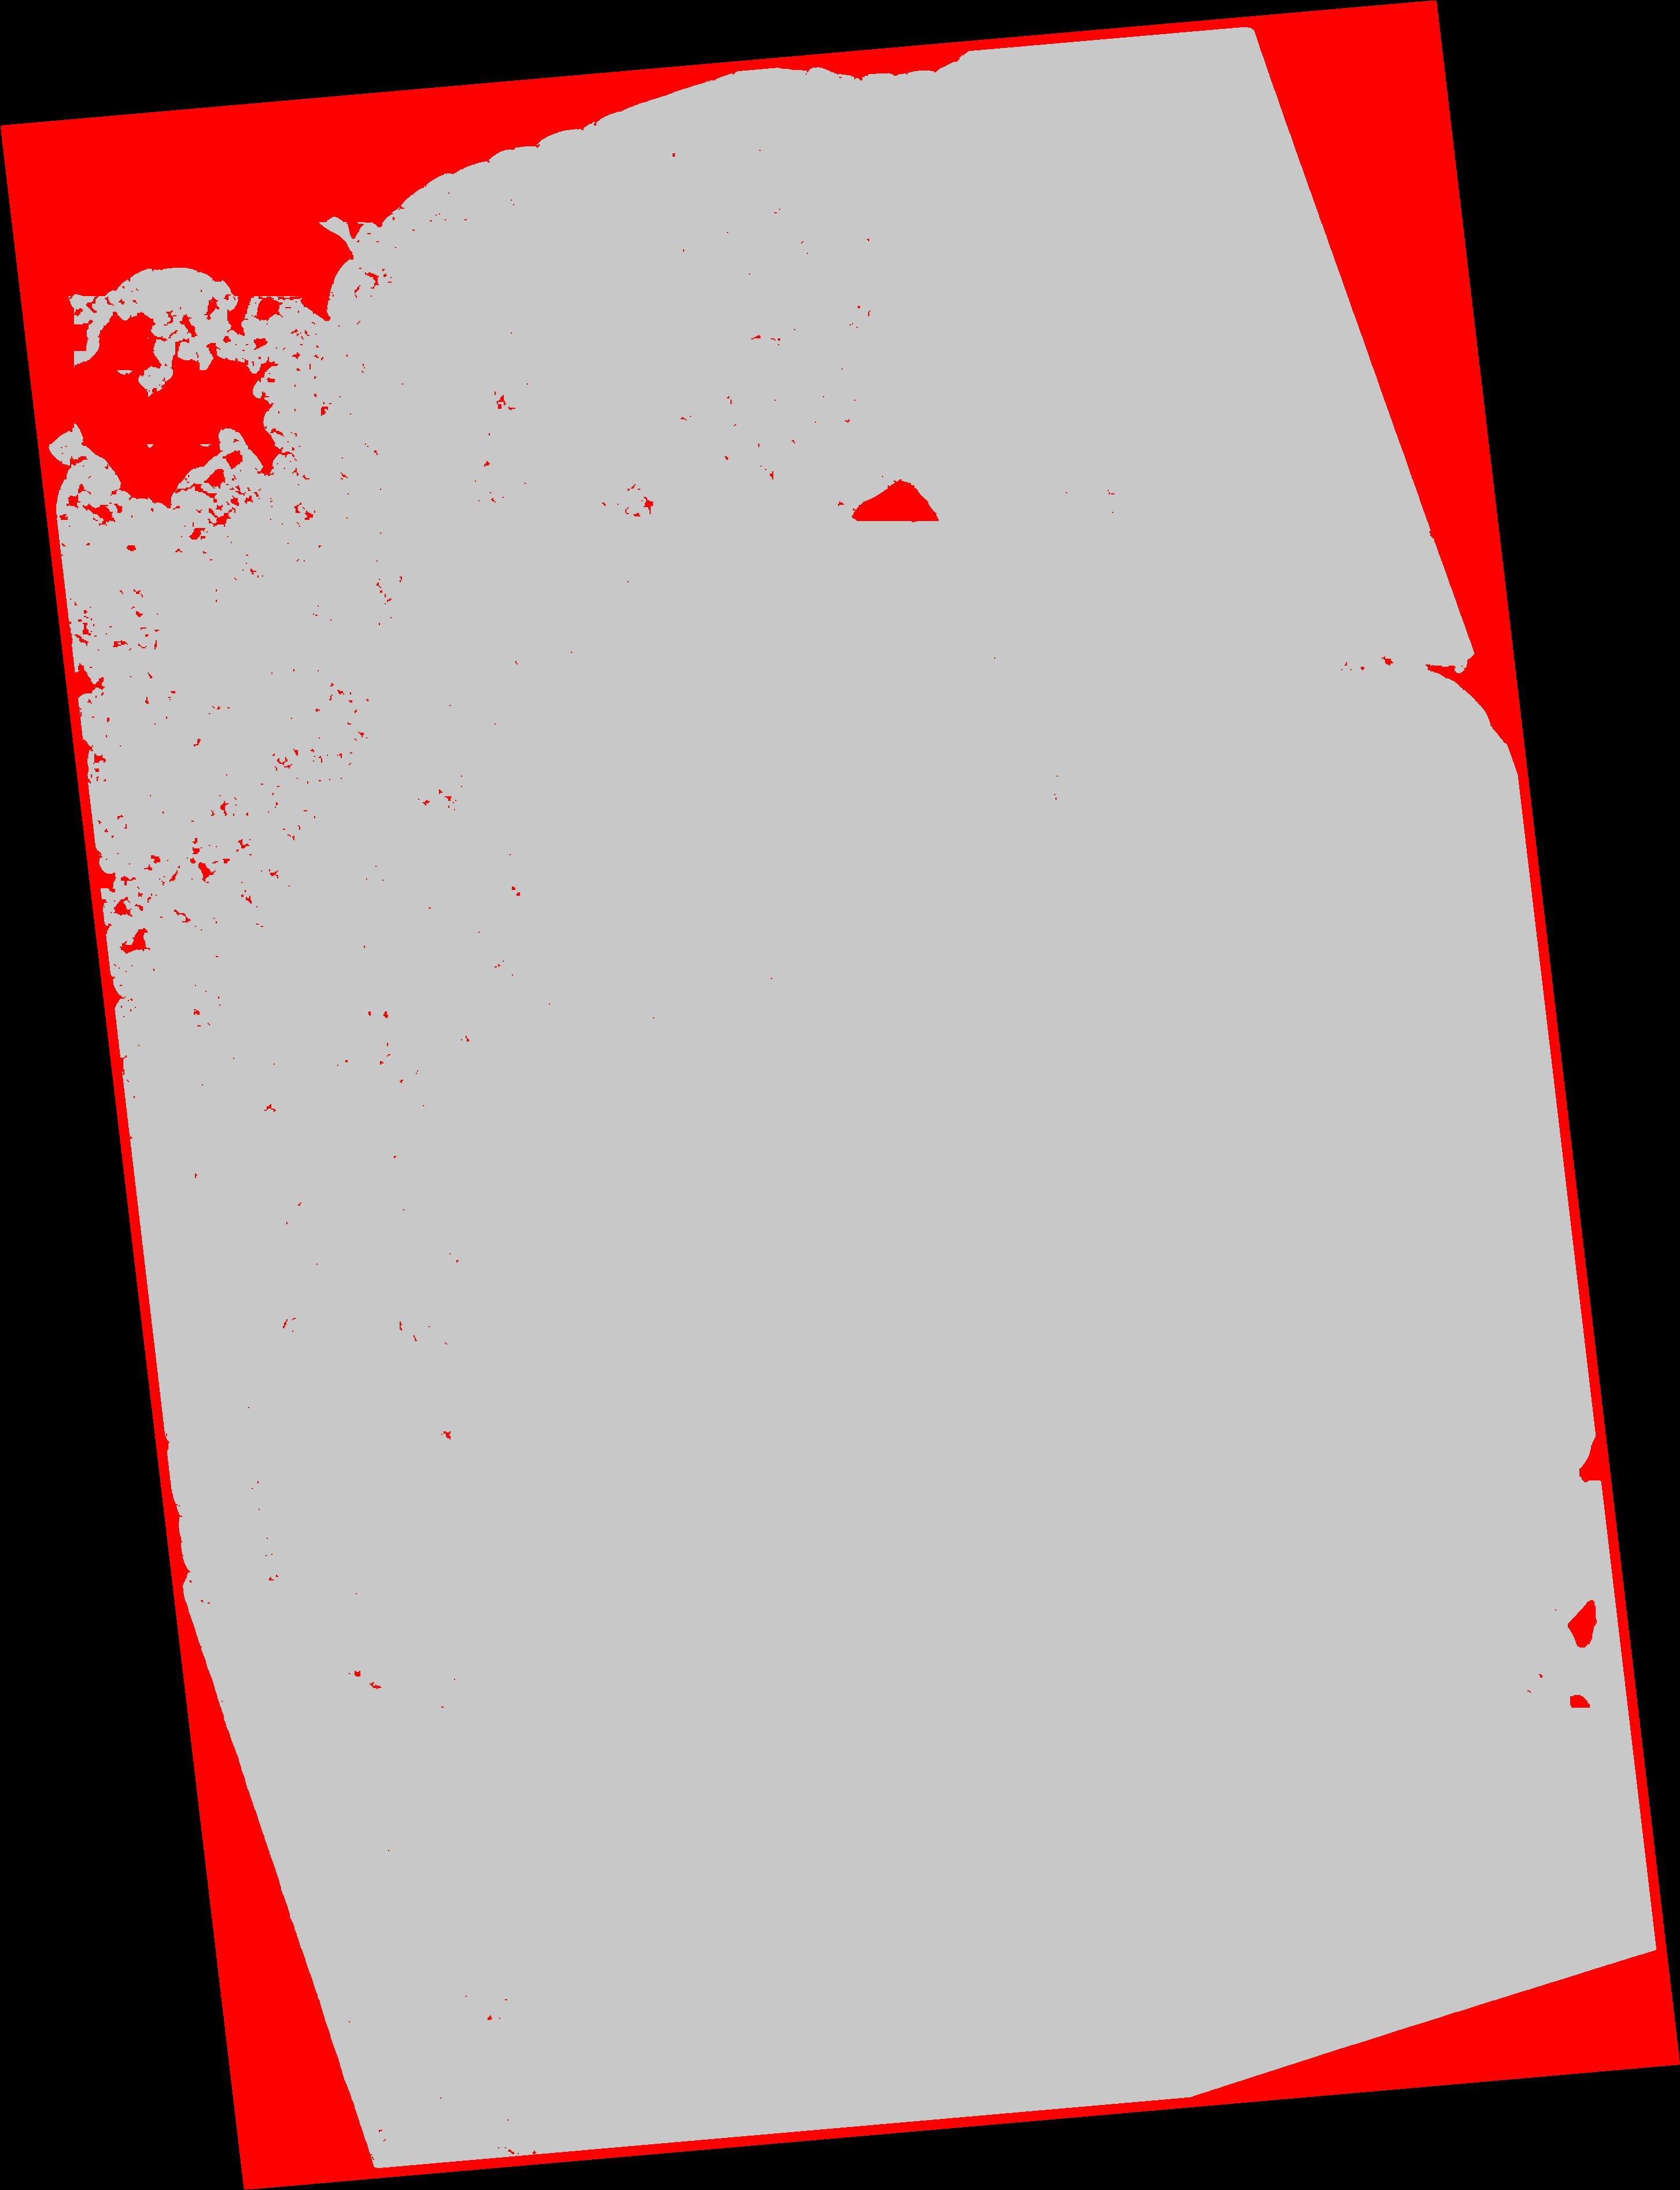

In [28]:
Image(filename=out, width=800)

## Hillshade of low res DEM

Now again for the hillshade

In [29]:
# both = f'{left}_{right}'
img = f'{dem_workdir}/{dem.stem}-hillshade.tif'
out = img.replace('.tif', '.png')

Convert to a png file again.

In [30]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

Input file size is 414, 454
0...10...20...30...40...50...60...70...80...90...100 - done.


Display the image in the notebook.

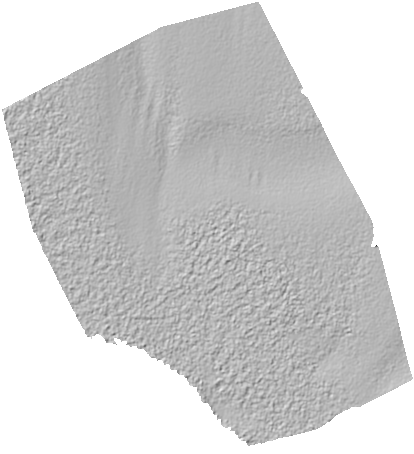

In [31]:
Image(filename=out, width=800)

# 9. Mapproject ctx against 100m DEM

We now map-project our ctx images against our low resolution DEM to reduce image distortion for our 2nd pass DEM.

`!asap ctx step_9 --mpp {img_gsd} {asap.kwarg_parse(step_kwargs, 'step_9')} 2>&1 | tee -i -a ./5_mapproject_to_100m_dem.log ./full_log.log`

In [20]:
""""
Mapproject the left and right ctx images against the reference DEM

:param run: name of run
:param refdem: reference dem to map project using
:param mpp: target GSD
:param postfix: postfix for cub files to use
:param camera_postfix: postfix for cameras to use
"""
asp.mapproject_both(ref_dem=dem.absolute(), mpp=img_gsd, bundle_adjust_prefix='adjust/ba')

# Started: mapproject_both (Mapproject the left and right images against a reference DEM), at: 2025-06-02 09:28:20.924901


INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalinfo -json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub', pid 36804>: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_camrange: process started
/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/src/asp_wrapper.py:507: RuntimeWarning: True image GSD is possibly too big for provided mpp value of 6.0 (compare to 3xGSD=16.0501796254227)
  if mpp < true_gsd * 3:
INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalinfo -json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub', pid 36829>: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=U15_076642_0916_XN_88S273W.lev1.eo.cub to=U15_0

mapproject_single --query-projection /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_100_0-DEM.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.ba.map.tif --mpp 6.0 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c

INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/mapproject /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_100_0-DEM.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.ba.map.tif --mpp 6.0 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba: process started


mapproject_single --query-projection /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_100_0-DEM.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.ba.map.tif --mpp 6.0 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba
	--> Setting number of processing threads to: 4
Using session: csm
Loading camera model: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub /mnt/c

# 10. Calculate Better DEM using prior

Same as step 5, just using the new map projected images this time.

`!asap ctx step_10 {config2} {asap.kwarg_parse(step_kwargs, 'step_10')} 2>&1 | tee -i -a ./6_next_level_dem.log ./full_log.log`

In [ ]:
asp.stereo_asap(
    run='results_map_ba',
    cub_postfix='.ba.map.tif',
    cam_postfix='.lev1.eo.json',
    ref_dem=dem.absolute(),
    entry_point=0,
    stop_point=5,
    stereo_algorithm='asp_mgm',
    subpixel_mode=3,
    corr_memory_limit_mb=16384,
)

# Started: stereo_asap (Runs parallel_stereo command.), at: 2025-06-02 09:37:30.246584


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/parallel_stereo --stereo-algorithm asp_mgm --processes 2 --threads-singleprocess 16 --threads-multiprocess 8 --subpixel-mode 3 --corr-memory-limit-mb 16384 --entry-point 0 --stop-point 5 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.ba.map.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.ba.map.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyam

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 256 pixels.

[ 2025-Jun-02 09:37:33 ]: Stage 0 --> PREPROCESSING
	--> Setting number of processing threads to: 16
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-log-stereo_pprc-06-02-0937-40522.txt
Using session: csmmapcsm
Images before mapprojection: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub
Mapprojection cameras: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo

Same as step 6, just using the new map projected images this time.

`!asap ctx step_11 {config2} {asap.kwarg_parse(step_kwargs, 'step_11')} 2>&1 | tee -i -a ./6_next_level_dem.log ./full_log.log`

In [ ]:
asp.stereo_asap(
    run='results_map_ba',
    cub_postfix='.ba.map.tif',
    cam_postfix='.lev1.eo.json',
    ref_dem=dem.absolute(),
    entry_point=5,
    stop_point=6,
    stereo_algorithm='asp_mgm',
    subpixel_mode=3,
    corr_memory_limit_mb=16384,
)

# Started: stereo_asap (Runs parallel_stereo command.), at: 2025-06-02 09:57:36.762076


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/parallel_stereo --stereo-algorithm asp_mgm --processes 2 --threads-singleprocess 16 --threads-multiprocess 8 --subpixel-mode 3 --corr-memory-limit-mb 16384 --entry-point 5 --stop-point 6 --bundle-adjust-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/adjust/ba /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.ba.map.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.ba.map.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyam

Using tiles (before collar addition) of 2048 x 2048 pixels.
Using a collar (padding) for each tile of 256 pixels.

[ 2025-Jun-02 09:57:39 ]: Stage 5 --> TRIANGULATION
	--> Setting number of processing threads to: 16
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-log-stereo_tri-06-02-0957-51167.txt
Using session: csmmapcsm
Images before mapprojection: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/U15_076642_0916_XN_88S273W.lev1.eo.cub
Mapprojection cameras: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.

We have made our second point cloud, so we should export some visuals as before. The parameter ‘–folder’ just specifies that we are saving things into a different directory this time around.

`!asap ctx step_7 --mpp {dem_gsd} --run results_map_ba {asap.kwarg_parse(step_kwargs, 'step_7_2')}`



In [24]:
asp.point_to_dem(24, 'PC.tif', run='results_map_ba')

# Started: point_to_dem, at: 2025-06-02 10:04:43.980397


INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4', pid 54592>: process started
/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/src/asp_wrapper.py:381: UserWarning: No SRS info, falling back to use ISIS caminfo.
 exception was: 

  RAN: /home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4

  STDOUT:


  STDERR:
ERROR 1: ERROR - failed to load SRS definition from /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub

  warnings.warn(
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_ca

	--> Setting number of processing threads to: 16
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_24_0-log-point2dem-06-02-1004-54676.txt
	--> Re-referencing altitude values using datum: D_MARS.
	    Axes [3.39619e+06 3.39619e+06] meters.
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [******************************************] 63%
Collected a sample of 29606081 positive triangulation errors.
Error percentiles: Q1 (25%): 2.40652, Q2 (50%): 7.05913, Q3 (75%): 13.637.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 40.9109 meters.
	Starting DEM rasterization
	--> DEM spacing: 24 pt/px
	             or: 0.0416667 px/pt
Creating output file that is Vector2(1671,1824) px.
Writing: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_09

`!asap ctx step_8 --run results_map_ba`

In [26]:
_left_img, _right_img = asp._get_pair()
dem_workdir = asp.stereo_pair.workdir + 'dem/'
dem: Path = next(Path(dem_workdir).glob('*24_0-DEM.tif'))
asp.hillshade(dem.absolute(), f'{dem_workdir}/{dem.stem}-hillshade.tif')

INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/gdaldem hillshade /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_align_24_0-DEM.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem//out-DEM_map_ba_align_24_0-DEM-hillshade.tif: process started


0...10...20...30...40...50...60...70...80...90...100 - done.


''

## Show previews

### Make Final GoodPixelMap and Hillshade Previews

Nothing too surprising here, just export PNG versions of the images we care about to see the DEM at this stage of the processing.

In [ ]:
both = f'{left}_{right}'
img = f'./{both}/results_map_ba/{both}_ba-GoodPixelMap.tif'
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=800)

### Hillshade of higher res DEM

In [ ]:
both = f'{left}_{right}'
img = './' + str(next(Path('../src/pyameslib/').glob(f'./{both}/results_map_ba/dem/{both}_ba_*-DEM-hillshade.tif')))
out = img.replace('.tif', '.png')

In [ ]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

In [ ]:
Image(filename=out, width=600)

# 11. PC alignment (Step 5)
The final important step in the make_dem workflow is to get the MOLA PEDR data for the region we care about. Again, our data is not completely done until it has been aligned to the MOLA topography. If we had GCPs in the bundle adjust stage this would not be as big of an issue, but since it is relatively easy to align to MOLA we don’t need to go through the process of producing GCPs.

There are two possibilities, either refdem is none (in which case get pedr data using moody) or we are given a dem
currently this will always run even if refdem is provided, but below pc_align call will use refdem if it's not none

`!asap ctx step_12 {refdem} 2>&1 | tee -i -a ./7_pedr_for_pc_align.log ./full_log.log`

In [36]:
asp.get_pedr_4_pcalign_w_moody(
    cub_path=asp.stereo_pair.left + '.lev1.eo.cub',
    proj=ctx.proj,
    output_prefix="pedr4align"
)

# Started: get_pedr_4_pcalign_w_moody (Python replacement for pedr_bin4pc_align.sh), at: 2025-06-02 12:07:14.150194


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_camrange: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/ogr2ogr -f CSV -sql 'SELECT Lat, Lon, Planet_Rad - 3396190.0 AS Datum_Elev, Topography FROM "MolaPEDR_-89N-88N_76E105E_20250602T040533394_shp_z"' /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pedr4align.csv /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pedr/MolaPEDR_-89N-88N_76E105E_20250602T040533394_shp_z.shp: process started
INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4', pid 78713>: process started
/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/src/asp_wrapper.py:386:

# Finished: get_pedr_4_pcalign_w_moody (Python replacement for pedr_bin4pc_align.sh), at: 2025-06-02 12:07:25.807064, duration: 0:00:11.656870


## Show pedr data

One additional bit here, for the MOLA data, show the PEDR2TAB template if created and the amount of PEDR data we have to align to. If the final line is less than a few hundred we could be in a bad situation.

In [ ]:
# !cat {asp.stereo_pair.workdir}PEDR2TAB.PRM

In [ ]:
# !cat ./{left}_{right}/{left}_{right}_pedr4align.csv | wc -l

Now that we have finished the first half of the workflow we can inspect the output products for issues before moving forwards. If there are issues noted in the log or after a particular step, that step can be re-run with different parameters until a good solution is found.

At this point, we have a completed DEM! However, it’s absolute position in space maybe off from the correct position. Therefore, we must now perform a point cloud alignment to align our DEM with reference topography, in this case MOLA PEDR data to correct the position of the CTX DEM. In older versions of ASAP, this point is the dividing line between the make_dem and align_dem pipelines.

The “maxdisp” parameter in particular deserves attention. It is the number passed to pc_align's –max-displacement parameter in the Ames Stereo Pipeline. Basically, it is the value of the distance you expect to move the CTX DEM to become aligned to your reference DEM (in this case, the PEDR data). It is generally worth estimating this number using a GIS to sample points in both the DEM and reference file, and seeing how far away they are from each other. But, CTX can be well-behaved with ASP, so we pick a default of 500 meters which can be large enough for many situations.

# 12. Start of PC align portion

### Align the DEM to MOLA

This is the most important step in the 2nd half of the workflow as all the remaining steps are just producing final science products and visuals for the logs. This step runs pc_align using the provided max displacement (aka disparity). If the logs indicate a larger displacement was observed than the user provided value it will need to be re-run using larger values or with other advanced parameters. If users see issues it is generally easyier to re-run the pipeline at this step repeatedly in the command line or inside the Jupyter notebook.

`!asap ctx step_13 --maxd {max_disp} --refdem {refdem} {asap.kwarg_parse(step_kwargs, 'step_13')} 2>&1 | tee -i -a ./8_pc_align.log ./full_log.log`


In [42]:

asp.point_cloud_align(
    datum="D_MARS",
    max_disparity=1000,
    src_dem =asp.workdir +"results_map_ba/out-PC.tif",
    ref_dem=asp.workdir + "pedr4align.csv",
    kind='map_ba_align',
)

# Started: point_cloud_align, at: 2025-06-02 12:16:24.829713


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/pc_align --save-inv-transform --num-iterations 4000 --alignment-method fgr --threads 16 --datum D_MARS --max-displacement 1000 --output-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pc_align/out-PC_map_ba_align --csv-format '1:lat 2:lon 3:height_above_datum' --highest-accuracy /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-PC.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pedr4align.csv: process started


	--> Setting number of processing threads to: 16

Creating output directory: "/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pc_align".
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/pc_align/out-PC_map_ba_align-log-pc_align-06-02-1216-80781.txt
Detected datum from /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-PC.tif:
Geodetic Datum --> Name: D_MARS  Spheroid: MARS  Semi-major axis: 3396190  Semi-minor axis: 3396190  Meridian: Reference meridian at 0  Proj4 Str: +proj=longlat +R=3396190 +no_defs
Will use datum (for CSV files): Geodetic Datum --> Name: D_MARS  Spheroid: MARS  Semi-major axis: 3396190  Semi-minor axis: 3396190  Meridian: Reference meridian at 0  Proj4 Str: +proj=longlat +R=3396190 +no_defs
Computing the bounding boxes of the reference and source points using 1000000 s

### Make the final CTX DEM

After the previous step everything after is simple and easy as we now have a final aligned point cloud from which DEMs and ortho images can be made. That is all the rest of the steps do, they generate final DEMs with the geoid adjustment to produce science ready DEMs and ortho images for mapping.

`!asap ctx step_14 --mpp {demgsd}  2>&1 | tee -i -a ./9_dems_orthos.log ./full_log.log`

In [44]:
asp.point_to_dem(
    mpp=img_gsd,
    pc_suffix = 'trans_reference.tif',
    just_ortho=False,
    run='pc_align',
    kind='map_ba_aligned',
    use_proj=ctx.proj,
)

# Started: point_to_dem, at: 2025-06-02 12:26:29.455145


INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4', pid 84661>: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_camrange: process started
INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalinfo -json /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub', pid 84686>: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_camrange: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/point2dem --threads 16 --reference-spheroid mars --nodata -32767 --output-prefix /mnt/c/Users/Ivan/Document

	--> Setting number of processing threads to: 16
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-log-point2dem-06-02-1226-84779.txt
	--> Re-referencing altitude values using datum: D_MARS.
	    Axes [3.39619e+06 3.39619e+06] meters.
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [******************************************] 63%
Collected a sample of 29606081 positive triangulation errors.
Error percentiles: Q1 (25%): 2.40652, Q2 (50%): 7.05913, Q3 (75%): 13.637.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 40.9109 meters.
	Starting DEM rasterization
	--> DEM spacing: 6 pt/px
	             or: 0.166667 px/pt
Creating output file that is Vector2(6675,7290) px.
Writing: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_091

### Adjust final CTX DEM to Geoid (Areoid)

`!asap ctx step_15 2>&1 | tee -i -a ./10_geoid_adjustment.log  ./full_log.log`


In [50]:
asp.geoid_adjust(
    src_dem_sfx = "6_0-DEM.tif",
    run = asp.workdir + "dem"
)

# Started: geoid_adjust (Adjust DEM to geoid), at: 2025-06-02 12:43:25.911707


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/dem_geoid /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM.tif -o /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM-geoid: process started


	--> Setting number of processing threads to: 4
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM-geoid-log-dem_geoid-06-02-1243-94020.txt
	Found input nodata value for /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM.tif: -32767
Adjusting the DEM using the geoid correction: /home/ivan/miniconda3/envs/asp/share/geoids/mola_areoid.tif
Writing adjusted DEM: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM-geoid-adj.tif
        --> Applying DEM adjustment: [************************************] 99%
# Finished: geoid_adjust (Adjust DEM to geoid), at: 2025-06-02 12:43:37.594893, duration: 0:00:11.683186


### Make the final CTX Hillshade and Orthos

`!asap ctx step_8 --folder results_map_ba --output_folder dem_align 2>&1 | tee -i -a ./11_hillshade.log ./full_log.log`

In [51]:
_left_img, _right_img = asp._get_pair()
dem_workdir = asp.stereo_pair.workdir + 'dem/'
dem: Path = next(Path(dem_workdir).glob('*6_0-DEM-geoid-adj.tif'))
asp.hillshade(dem.absolute(), f'{dem_workdir}/{dem.stem}-hillshade.tif')

INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/gdaldem hillshade /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_6_0-DEM-geoid-adj.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem//out-DEM_map_ba_aligned_6_0-DEM-geoid-adj-hillshade.tif: process started


0...10...20...30...40...50...60...70...80...90...100 - done.


''

In [52]:
img = f'{dem_workdir}/{dem.stem}-hillshade.tif'
out = img.replace('.tif', '.png')

In [53]:
!gdal_translate -of PNG -co worldfile=yes {img} {out}

Input file size is 6675, 7290
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
Image(filename=out, width=800)

`!asap ctx step_14 --mpp {img_gsd} --just_ortho True  2>&1 | tee -i -a ./12_img_full_ortho.log ./full_log.log`


In [56]:
asp.point_to_dem(
    mpp=img_gsd,
    pc_suffix = 'out-PC.tif',
    just_ortho=True,
    run='results_map_ba',
    kind='map_ba_aligned_ortho',
    use_proj=ctx.proj,
)

# Started: point_to_dem, at: 2025-06-02 12:54:03.717385


INFO:sh.command:<Command '/home/ivan/miniconda3/envs/asp/bin/gdalsrsinfo /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/K14_059010_0916_XN_88S273W.lev1.eo.cub -o proj4', pid 98584>: process started
INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/camrange from=K14_059010_0916_XN_88S273W.lev1.eo.cub to=K14_059010_0916_XN_88S273W.lev1.eo_camrange: process started


{'--reference-spheroid': 'mars', '--nodata': -32767, '--output-prefix': '/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_ortho_6_0', '--dem-spacing': 6.0, '--t_srs': '+proj=ortho +lon_0=90.207069876083 +lat_0=-88.46295929257 +x_0=0 +y_0=0 +a=3396190.0 +b=3396190.0 +units=m +no_defs', '--orthoimage': '/mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-L.tif'}


INFO:sh.command:/home/ivan/miniconda3/envs/asp/bin/point2dem --threads 16 --reference-spheroid mars --nodata -32767 --output-prefix /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_ortho_6_0 --dem-spacing 6.0 --t_srs '+proj=ortho +lon_0=90.207069876083 +lat_0=-88.46295929257 +x_0=0 +y_0=0 +a=3396190.0 +b=3396190.0 +units=m +no_defs' --orthoimage /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-L.tif /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/results_map_ba/out-PC.tif --no-dem: process started


	--> Setting number of processing threads to: 16
Writing log: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_ortho_6_0-log-point2dem-06-02-1254-98641.txt
	--> Re-referencing altitude values using datum: D_MARS.
	    Axes [3.39619e+06 3.39619e+06] meters.
Bounding box and triangulation error range estimation: [******************] 99%
Point cloud extent estimation: [******************************************] 63%
Collected a sample of 29606081 positive triangulation errors.
Error percentiles: Q1 (25%): 2.40652, Q2 (50%): 7.05913, Q3 (75%): 13.637.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 40.9109 meters.
	Starting DEM rasterization
	--> DEM spacing: 6 pt/px
	             or: 0.166667 px/pt
Writing: /mnt/c/Users/Ivan/Documents/PROJECTS/Python/pyameslib/notebooks/output/a_K14_059010_0916_U15_076642_0916/dem/out-DEM_map_ba_aligned_ortho_6_0-DRG.tif